# Sparkify Project Workspace

# Project Overview :- 

<p>This is udacity's capstone project, using spark to analyze user behavior data from music app Sparkify.</p>

<p>Sparkify is a music app, this dataset contains two months of sparkify user behavior log. The log contains some basic information about the user as well as information about a single action. A user can contain many entries. In the data, a part of the user is churned, through the cancellation of the account behavior can be distinguished.</p>

<p>we will work on the given data set and engineer relevant features for predicting churn.</p>

<p>Customer churn is when an existing customer, user, player, subscriber or any kind of return client stops doing business or ends the relationship with a company.</p>
<p>so lets get started...</p>

In [ ]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, avg, desc,countDistinct, count, when, concat, lit
from pyspark.sql.types import IntegerType, DateType

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.sql import Window
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
print("Total Number of records:", df.count())

Total Number of records: 286500


In [6]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
artist,228108,551.0852017937219,1217.7693079161374,!!!,ÃÂlafur Arnalds
auth,286500,None,None,Cancelled,Logged Out
firstName,278154,None,None,Adelaida,Zyonna
gender,278154,None,None,F,M
itemInSession,286500,114.41421291448516,129.76726201140994,0,1321
lastName,278154,None,None,Adams,Wright
length,228108,249.1171819778458,99.23517921058361,0.78322,3024.66567
level,286500,None,None,free,paid
location,278154,None,None,"Albany, OR","Winston-Salem, NC"


In [7]:
print('Empty string in userId:- ',df.filter(df["userId"] == "").count())

Empty string in userId:-  8346


In [8]:
# Althought it does not look any NA value but droping the NA value for safer side
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
# removing the empty string 
df = df.filter(df["userId"] != "")
#counting the the remaning and it should be 286500 - 8346 = 278154
df.count()

278154

In [9]:
# validating intial 5 rows
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [10]:
# Perhaps it is best to remove both 'Logged Out' and 'Guest' values in 'auth' column as we are tring to predict if the users 
# will churn or not. Both 'Logged Out' and 'Guest' have userIds missing.
df = df.filter((df.auth != 'Guest') & (df.auth != 'Logged Out'))
df.select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
churned_user_ids = df.filter(df.page == 'Cancellation Confirmation')\
                                            .select('userId')\
                                            .dropDuplicates()\
                                            .rdd.flatMap(lambda x : x)\
                                            .collect()

In [12]:
df = df.withColumn('churn', when(col("userId").isin(churned_user_ids), 1).otherwise(0))

In [13]:
# validating that above logic worked fine or not
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', churn=0)]

In [14]:


# Looks like 'Cancelled' in 'auth' column also represents churn. Lets find out churn ratio just for fun.

# Dataframe method
# df.filter((col('userId').isNotNull()) & (col('userId') != ''))\
#                         .groupby('auth').agg(countDistinct('userId')\
#                         .alias('unique_user_count')).show()

df.createOrReplaceTempView('df_table')

# SQL method
df_auth = spark.sql("SELECT auth, COUNT(DISTINCT userId) as unique_user_count\
                     FROM df_table\
                     WHERE userId IS NOT NULL AND userID != ''\
                     GROUP BY auth\
                     ORDER BY unique_user_count DESC")

df_auth.show()

n_users_registered = df_auth.filter(col('auth') == 'Logged In')\
                             .select('unique_user_count').first()[0]
n_users_left = df_auth.filter(col('auth') == 'Cancelled')\
                             .select('unique_user_count').first()[0]

print('The number of users registered: {} and the number of users left: {} with a churn ratio of: {}'\
                             .format(n_users_registered,n_users_left,round((n_users_left/n_users_registered),2)))

+---------+-----------------+
|     auth|unique_user_count|
+---------+-----------------+
|Logged In|              225|
|Cancelled|               52|
+---------+-----------------+

The number of users registered: 225 and the number of users left: 52 with a churn ratio of: 0.23


In [15]:
# Let's find the average number of songs played by churned and unchurned user.
df_songs_count = df.filter(col('page')=='NextSong')\
                                .groupby(col('churn'))\
                                .count()

df_songs_unique_users = df.filter(col('page')=='NextSong')\
                                .groupby(col('churn'))\
                                .agg(countDistinct(col('userId')))

avg_num_songs_played = df_songs_unique_users\
                .join(df_songs_count, df_songs_count.churn == df_songs_unique_users.churn)\
                .drop(df_songs_count.churn)

avg_num_songs_played = avg_num_songs_played\
                .withColumn('AvgNumberofSongs', \
                avg_num_songs_played['count']/avg_num_songs_played['count(DISTINCT userId)'])

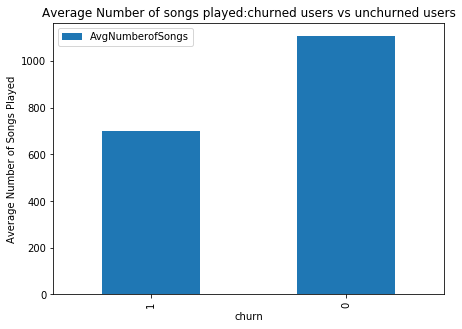

In [16]:
df_plt = avg_num_songs_played.select(['churn', 'AvgNumberofSongs']).toPandas().set_index('churn')
df_plt.plot(kind = 'bar', figsize = (7, 5), title = 'Average Number of songs played:churned users vs unchurned users');
plt.ylabel('Average Number of Songs Played');

In [17]:
# Average number of times each page is vistied: churned vs unchurned users.
df_page_churn_count = df.groupby(['churn','page']).agg({'page':'count'})

avg_num_page_visit = df_page_churn_count\
                .join(df_songs_unique_users, df_songs_unique_users.churn == df_page_churn_count.churn)\
                .drop(df_songs_unique_users.churn)

avg_num_page_visit = avg_num_page_visit\
                .withColumn('AvgNumberofPageVisit', \
                            avg_num_page_visit['count(page)']/avg_num_page_visit['count(DISTINCT userId)'])

In [18]:
# I am leaving out "NextSong" page as it dominates every other page, moreover NextSong has been shown seperately in the plot
# above.
avg_num_page_visit = avg_num_page_visit.filter(col('page') != 'NextSong')
avg_num_page_visit = avg_num_page_visit.toPandas()

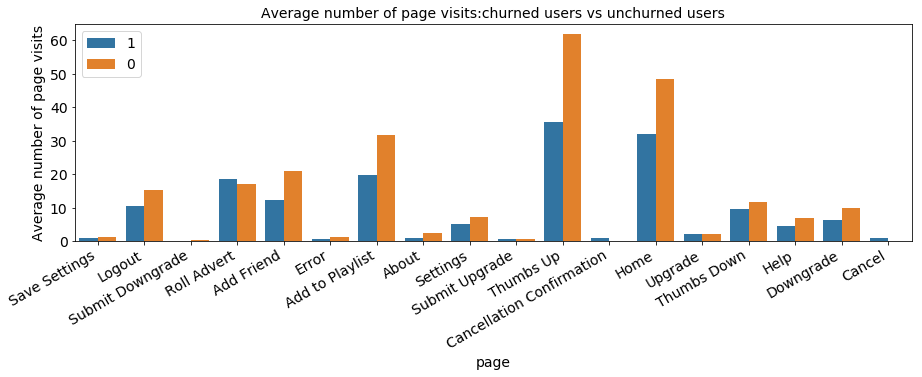

In [19]:
# Plotting average number of times each page is vistied: churned vs unchurned users.
fig = plt.figure(figsize=(15, 4))
sns.barplot(x="page",y="AvgNumberofPageVisit", hue="churn", data=avg_num_page_visit, hue_order=[1, 0]);
plt.xticks(rotation=90, fontsize=14);
plt.yticks(fontsize=14)
plt.xlabel("page", fontsize=14)
plt.ylabel("Average number of page visits", fontsize=14)
plt.title("Average number of page visits:churned users vs unchurned users", fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.legend(loc='best', fontsize=14);

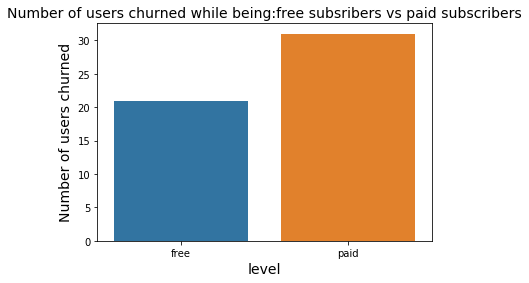

In [20]:
# number of users churned while being free subsribers vs paid subscribers
df_pd = df.filter(col('churn')==1).filter(df['page']=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_pd);
plt.xlabel("level", fontsize=14);
plt.ylabel("Number of users churned", fontsize=14);
plt.title("Number of users churned while being:free subsribers vs paid subscribers", fontsize=14);

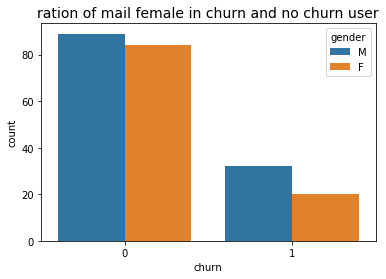

In [21]:
# just wanted to check ration of mail female in churn and no churn user
df_gen = df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_gen)
plt.title("ration of mail female in churn and no churn user", fontsize=14);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

After analyzing all the column above i have decided to use below fetaure in my model:<br/>
1:- Gender<br/>
2:- UserAgent<br/>
3:- Status<br/>
4;- Page<br/>

<p>Once the columns were identified, we now have to make sure that they are al in the numeric datatype so that they could be put into the model that we choose. The Gender, UserAgent and page columns had to be converted into numeric values using a combination of String Indexing and One Hot encoding.</p>


In [22]:
#build pipeline
Gender_indexer = StringIndexer(inputCol="gender", outputCol='Gender_Index')
User_indexer = StringIndexer(inputCol="userAgent", outputCol='User_Index')
Page_indexer = StringIndexer(inputCol="page", outputCol='Page_Index')
Gender_encoder = OneHotEncoder(inputCol='Gender_Index', outputCol='Gender_Vec')
User_encoder = OneHotEncoder(inputCol='User_Index', outputCol='User_Vec')
Page_encoder = OneHotEncoder(inputCol='Page_Index', outputCol='Page_Vec')
assembler = VectorAssembler(inputCols=["Gender_Vec", "User_Vec", "Page_Vec", "status"], outputCol="features")
indexer = StringIndexer(inputCol="churn", outputCol="label")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [23]:
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
pipeline = Pipeline(stages=[Gender_indexer, User_indexer, Page_indexer, Gender_encoder,
                            User_encoder, Page_encoder, assembler, indexer, lr])

In [24]:
#Train Test Split: As a first step break your data set into 90% 
#of training data and set aside 10%. Set random seed to 42.
rest, validation = df.randomSplit([0.9, 0.1], seed=42)

In [25]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1, ]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [26]:
cvModel_q1 = crossval.fit(rest)

In [27]:
cvModel_q1.avgMetrics

[0.8517259834722277, 0.8539187024054737]

In [28]:
# instantiating random forests model
rf = RandomForestClassifier(labelCol="label",\
                            featuresCol="ScaledFeatures",\
                            featureSubsetStrategy='sqrt')

# creating pipeline
pipeline_rf = Pipeline(stages=[Gender_indexer, User_indexer, Page_indexer, Gender_encoder,
                            User_encoder, Page_encoder, assembler, indexer, lr])

# building paramgrid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.impurity,['entropy', 'gini']) \
    .addGrid(rf.maxDepth,[2, 4, 6, 8]) \
    .addGrid(rf.numTrees,[10, 25, 50, 100]) \
    .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,\
                             estimatorParamMaps=paramGrid,\
                             evaluator=MulticlassClassificationEvaluator(),\
                             numFolds=3)

cvModel_rf = crossval_rf.fit(rest)
results = cvModel_rf.transform(validation)

In [29]:
cvModel_rf.avgMetrics

[0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277,
 0.8517259834722277]

In [30]:
def model_performance_metrics(model, data, evaluation_metric):
    '''
    This function receives a ml model, the data that needs to be predicted and the evaluation metric, and
    then return the score and confusion matrix for the model.   
    
    :param model: ml model
    :param data: test data
    :param evaluation_metric: Parameter to evaluate the model with 
    :return:  the score and confusion matrix for the model
    '''
    scorer = MulticlassClassificationEvaluator(metricName = evaluation_metric)
    preds = model.transform(data)
    
    score = scorer.evaluate(preds)
    confusion_matrix = (preds.groupby("label").pivot("prediction").count().toPandas())      
    
    return score, confusion_matrix

In [31]:
score_lr, confusion_matrix_lr = model_performance_metrics(cvModel_q1, validation, 'f1')
print('the score for logistic regression model: {}'.format(score_lr))
confusion_matrix_lr

the score for logistic regression model: 0.8541307283976997


,label,0.0,1.0
0,0.0,23189,62
1,1.0,3195,1251


In [32]:
score_lr, confusion_matrix_lr = model_performance_metrics(cvModel_rf, validation, 'f1')
print('the score for logistic regression model: {}'.format(score_lr))
confusion_matrix_lr

the score for logistic regression model: 0.8541691823634296


,label,0.0,1.0
0,0.0,22867,384
1,1.0,3026,1420


# Improvement

As with anything in life, there is always room for improvement. One thing that could be looked more into, is to not only predict people that would cancel their subscription altogether, but to predict which paid users might downgrade to a free membership. This is also a concern to Sparkify, as this would lower their subscription fees that they would receive.


# Conclusion

<p>We are the done with project and below is the steps we follow</p>

1) Loaded the data<br>
2) Exploratory data analysis <br>
3) Feature engineering and checking for multi-collinearity<br>
4) Model building and evaluation<br>
5) Identifying important features <br>
6) Remedial actions to reduce churn <br>
7) Potential Improvements to the model.<br>

Overall, I would say that this was a very exciting project to work on. This was a real world scenario for many online business that rely on subscriptions (both paid and un-paid). Utilizing the Spark technologies allowed me to get a better feel of Big Data Technologies and all of the potential that it has out in the real world.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.